In [1]:
import pandas as pd
from itertools import combinations
import itertools
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from random import randrange
import matplotlib
import seaborn as sns
from itertools import permutations

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score,KFold

In [2]:
x_train  = pd.read_csv("split_1_train_X_Tesla_Cells_20220428.csv")
x_test  = pd.read_csv("split_1_test_X_Tesla_Cells_20220428.csv")
y_train  = pd.read_csv("split_1_train_y_Tesla_Cells_20220428.csv")
y_test  = pd.read_csv("split_1_test_y_Tesla_Cells_20220428.csv")

In [3]:
x_test.shape

(39, 365)

In [4]:
#removing datapoints where labels >20 000 Amp.h
# col = 'rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'
# x_train = x_train[y_train[col]<20000]
# y_train = y_train[y_train[col]<20000]

#removing column of filenames
x_train = x_train.drop('filename', axis = 1)
x_test = x_test.drop('filename', axis = 1)
y_test = y_test.drop('filename', axis = 1)
y_train = y_train.drop('filename', axis = 1)

#using log(labels)
train_labels= y_train["rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties"].tolist()
log_train_labels = np.log(train_labels)

In [7]:
print(max(train_labels), min(train_labels))

23439.13301297788 613.7561316073015


#### First correlation test with Variance feature (Severson 2019)

-0.7197473032995415


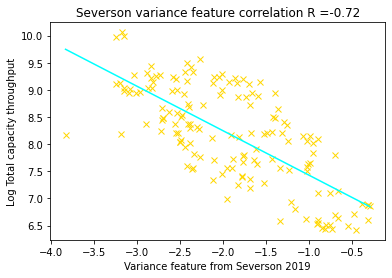

In [8]:
variance_feat = x_train['var_discharging_capacity::CycleSummaryStats'].tolist()

a,b = np.polyfit(variance_feat, log_train_labels,1 )
coef = np.corrcoef(variance_feat,log_train_labels)[0,1]
plt.plot(variance_feat, log_train_labels,'x',color='gold')
plt.plot([min(variance_feat),max(variance_feat)],[min(variance_feat)*a+b,a*max(variance_feat)+b],color = "cyan")
plt.xlabel('Variance feature from Severson 2019')
plt.ylabel('Log Total capacity throughput')
plt.title('Severson variance feature correlation R ={}'.format(round(coef,3)))
plt.savefig('Severson_feature.png')

print(coef)

In [9]:
##For comparison, the non_log feature of the variance is not as good:
non_log_feat = np.exp(np.asarray(variance_feat))
coef = np.corrcoef(non_log_feat,train_labels)[0,1]
print (coef)

-0.5459908068807883


#### Automating calculations of all correlation coeff for all features

In [10]:
def get_coef (feat,labels, plot = False):
    ### input: feature list, labels list, 
    ### return correlation coef between the feature and the labels
    
    a,b = np.polyfit(feat,labels,1 )
    coef = np.corrcoef(feat,labels)[0,1]
    if plot:
        plt.plot(feat, labels,'x',color='gold')
        plt.plot([min(feat),max(feat)],[min(feat)*a+b,a*max(feat)+b],color = "cyan")
        plt.xlabel('Feature')
        plt.ylabel('Total capacity throughput')
        plt.title('Feature correlation')
        print (f'correlation coef between the feature and the labels is {coef}')
    return coef

In [11]:
get_coef(variance_feat,log_train_labels)

-0.7197473032995415

In [13]:
coef_dict ={}
for key in x_train.keys():
    feature= x_train[key].tolist()
    coef = abs(np.corrcoef(feature, train_labels)[0,1])
    if coef > 0.001:
        coef_dict[key]=abs(coef)

coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1],reverse=True))

##printing a few: 
i=0
for key in coef_dict.keys():
    if i<10:
        print(f'feature: {key} gives a correlation of {coef_dict[key]}')
        i+=1
    
# print(f'First examples of the coef_dict are {list(coef_dict.items())[:10]}')


feature: abs_discharging_capacity::CycleSummaryStats gives a correlation of 0.7587100552701532
feature: square_discharging_capacity::CycleSummaryStats gives a correlation of 0.7299191120436507
feature: abs_mean_discharge_capacity_difference_cycles_2:100::DeltaQFastCharge gives a correlation of 0.7219953391133521
feature: mean_discharging_capacity::CycleSummaryStats gives a correlation of 0.7218496725963969
feature: m0_Amp_rpt_0.2C_1::RPTdQdVFeatures gives a correlation of 0.7084120467671581
feature: diag_1_Q_ne::IntracellFeaturesV2 gives a correlation of 0.7075351646387619
feature: diag_1_Q_ne_opt::IntracellFeaturesV2 gives a correlation of 0.7072033405715494
feature: r_d_end_50::HPPCResistanceVoltageFeatures gives a correlation of 0.7029593669784018
feature: r_d_end_60::HPPCResistanceVoltageFeatures gives a correlation of 0.6887076782295407
feature: diag_1_ne_soc_FC4p2V::IntracellFeaturesV2 gives a correlation of 0.6867699676109736


#### Correlation coef with log of labels

In [16]:
log_coef_dict ={}
# log train labels already defined at the beginning
# log_train_labels = np.log(train_labels) 

for key in x_train.keys():
    feature= x_train[key].tolist()
    coef = abs(np.corrcoef(feature, log_train_labels)[0,1])
    if coef >0.01:
        log_coef_dict[key]=abs(coef)

log_coef_dict = dict(sorted(log_coef_dict.items(), key=lambda item: item[1],reverse=True))

##printing a few: 
i=0
for key in log_coef_dict.keys():
    if i<10:
        print(f'feature: {key} gives a correlation of {log_coef_dict[key]}')
        i+=1




feature: diag_1_Q_ne_opt::IntracellFeaturesV2 gives a correlation of 0.7922030530562983
feature: diag_1_Q_ne::IntracellFeaturesV2 gives a correlation of 0.7921035632234126
feature: SOC40%_degrad50%::HPPCRelaxationFeatures gives a correlation of 0.7905133629677661
feature: abs_discharging_capacity::CycleSummaryStats gives a correlation of 0.7864729428148137
feature: D_4::HPPCResistanceVoltageFeatures gives a correlation of 0.783684353071476
feature: square_discharging_capacity::CycleSummaryStats gives a correlation of 0.783359686739268
feature: mean_discharging_capacity::CycleSummaryStats gives a correlation of 0.7797305168254852
feature: abs_mean_discharge_capacity_difference_cycles_2:100::DeltaQFastCharge gives a correlation of 0.7762350397344826
feature: diag_1_pe_voltage_FC4p2V::IntracellFeaturesV2 gives a correlation of 0.7756297472354049
feature: diag_1_ne_voltage_FC4p2V::IntracellFeaturesV2 gives a correlation of 0.7754744591262354


#### Train baseline linear model with 10 random features

In [17]:
d = len(x_train.keys())
pop = np.arange(0,d)
indices = random.choices(pop, k=10)

random_10_features =[]
for index in indices:
    random_10_features.append(x_train.keys()[index])

R10_x_train=x_train[random_10_features]
R10_x_test=x_test[random_10_features]

error for random pick features is 3102.497


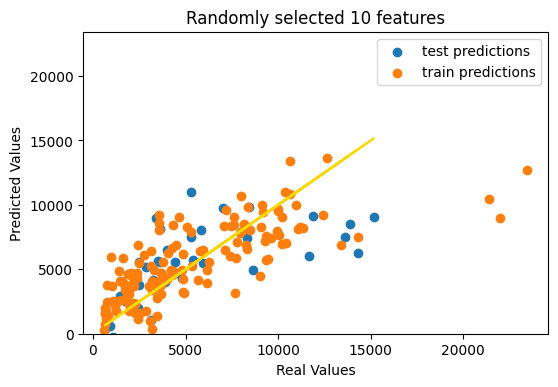

In [14]:
lm = linear_model.LinearRegression()
model = lm.fit(R10_x_train, y_train)
predictions = lm.predict(R10_x_test)
train_predictions = lm.predict(R10_x_train)
fig = plt.subplots(dpi = 100)
plt.scatter(y_test, predictions, label = 'test predictions')
plt.scatter(y_train, train_predictions, label = 'train predictions')
plt.plot(y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'], y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'],color="gold")
plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title("Randomly selected 10 features")
plt.legend(loc = 'best')


randomMSE = round(mean_squared_error(predictions, y_test)**0.5,3)
print(f'error for random pick features is {randomMSE}')


#### Training Linear model with Handpicked 10 highly correlated features

In [24]:
selected_features = ['var_discharging_capacity::CycleSummaryStats','slope_discharge_capacity_cycle_number_2:100::DeltaQFastCharge','diag_1_pe_soc_FC4p2V::IntracellFeaturesV2','r_d_end_50::HPPCResistanceVoltageFeatures','mean_discharging_capacity::CycleSummaryStats','D_4::HPPCResistanceVoltageFeatures','abs_discharging_capacity::CycleSummaryStats','SOC40%_degrad50%::HPPCRelaxationFeatures','diag_1_Q_ne_opt::IntracellFeaturesV2','diag_1_pe_voltage_FC4p2V::IntracellFeaturesV2']
selected_x_train = x_train[selected_features]
selected_x_test=x_test[selected_features]

error for handpicked features is 4510.452


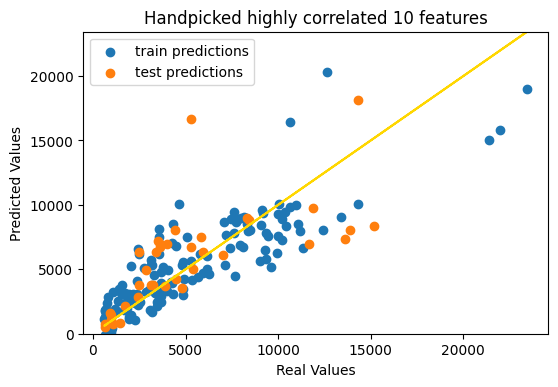

In [17]:
lm = linear_model.LinearRegression()
model = lm.fit(selected_x_train, y_train)
predictions = lm.predict(selected_x_test)
train_predictions = lm.predict(selected_x_train)
fig = plt.subplots(dpi = 100)
plt.scatter(y_train, train_predictions, label = 'train predictions')
plt.scatter(y_test, predictions, label = 'test predictions')
plt.plot(y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'], y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'],color="gold")
plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title("Handpicked highly correlated 10 features")
plt.legend(loc = 'best')


randomMSE = round(mean_squared_error(predictions, y_test)**0.5,3)
print(f'error for handpicked features is {randomMSE}')


## PCA analysis

#### Getting the PCA data

In [19]:
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

In [20]:
#after a few PCA iterations, we determined that 90% of the variance was encompassed by the first 22 components - see below)
pca = PCA(n_components = 22)
pca_x_train = pca.fit_transform(scaled_x_train)
pca_x_test = pca.transform(scaled_x_test)
# plt.scatter(scaled_x_train[:,0],scaled_x_train[:,1])

# variance = pca.explained_variance_ratio_*100
# cumul = []
# for i in range(len(variance)):
#     if  i == 0:
#         cumul.append(variance[i])
#     else:
#         cumul.append(cumul[i-1]+variance[i])
#     if cumul[-1]>90:
#         break
# print (cumul, len(cumul))

In [21]:
pca_2comp = PCA(n_components = 2)
pca_2comp_x_train =pca_2comp.fit_transform(scaled_x_train)
pca_2comp_x_test = pca.transform(scaled_x_test)

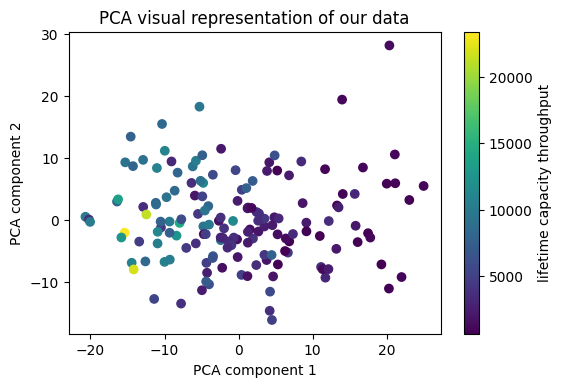

In [22]:
fig = plt.subplots(dpi = 100)
plt.scatter(pca_2comp_x_train[:,0],pca_2comp_x_train[:,1],c = train_labels)
cbar = plt.colorbar()
cbar.set_label('lifetime capacity throughput')
plt.ylabel('PCA component 2')
plt.xlabel('PCA component 1')
plt.title("PCA visual representation of our data")
plt.savefig('PCA_components_plot.png')

#### Test on classical Linear Regression Model

error for Linear Regression is 3982.516


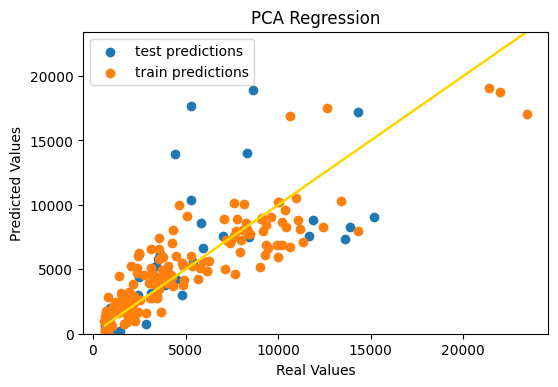

In [24]:
lm = linear_model.LinearRegression()
model = lm.fit(pca_x_train, y_train)
train_predictions = lm.predict(pca_x_train)
predictions = lm.predict(pca_x_test)

fig = plt.subplots(dpi = 100)
plt.scatter(y_test, predictions, label = 'test predictions')
plt.scatter(y_train, train_predictions, label = 'train predictions')
plt.plot(y_train, y_train,color="gold")
plt.ylim(0, y_train.max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title("PCA Regression")
plt.legend(loc = 'best')


randomMSE = round(mean_squared_error(predictions, y_test)**0.5,3)
print(f'error for Linear Regression is {randomMSE}')

#### Lasso on PCA data

error for Lasso is 3981.454


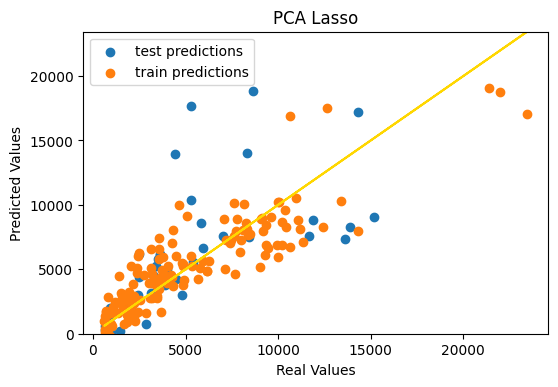

In [25]:
lm = linear_model.Lasso()
model = lm.fit(pca_x_train, y_train)
train_predictions = lm.predict(pca_x_train)
predictions = lm.predict(pca_x_test)

fig = plt.subplots(dpi = 100)
plt.scatter(y_test, predictions, label = 'test predictions')
plt.scatter(y_train, train_predictions, label = 'train predictions')
plt.plot(y_train, y_train,color="gold")
plt.ylim(0, y_train.max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title("PCA Lasso")
plt.legend(loc = 'best')


randomMSE = round(mean_squared_error(predictions, y_test)**0.5,3)
print(f'error for Lasso is {randomMSE}')

#### RF on PCA

error for RF is 3212.19


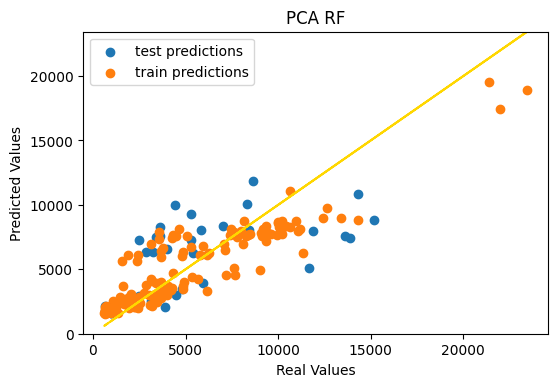

In [26]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

RF = RandomForestRegressor(max_depth=3, random_state=1)
RF.fit(pca_x_train, y_train)

train_predictions = RF.predict(pca_x_train)
predictions = RF.predict(pca_x_test)

fig = plt.subplots(dpi = 100)
plt.scatter(y_test, predictions, label = 'test predictions')
plt.scatter(y_train, train_predictions, label = 'train predictions')
plt.plot(y_train, y_train,color="gold")
plt.ylim(0, y_train.max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title("PCA RF")
plt.legend(loc = 'best')


randomMSE = round(mean_squared_error(predictions, y_test)**0.5,3)
print(f'error for RF is {randomMSE}')